In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd
import pickle

In [52]:
years = list(range(2001, 2024))
years_contracts = list(range(1996, 2024))

In [53]:
with open('./data/final_stats.pickle', 'rb') as statistics:
    final_stats = pickle.load(statistics)

In [54]:
stats_columns = ["ID", "salary_perc", "last_year_of_contract", "age", "games_played_perc", "games_started_perc", "minutes_played", "avg_minutes_played", "WS48", "PER", "team_successes",
              "defensive", "most_improved", "most_valuable", "most_valuable_finals", "sixth_man", "all_league", "all_def", "season"]
last_year_of_contracts = pd.DataFrame(columns=stats_columns)

In [55]:
for year in years[:-1]:
    contracts = pd.DataFrame()
    contracts = final_stats[year].query("last_year_of_contract == True").copy()
    contracts["season"] = year
    contracts = contracts.reset_index()
    last_year_of_contracts = pd.concat([last_year_of_contracts, contracts]).reset_index(drop=True)

In [56]:
last_year_of_contracts = last_year_of_contracts[(last_year_of_contracts["minutes_played"] > 96)].reset_index(drop=True)
last_year_of_contracts = last_year_of_contracts[(last_year_of_contracts["avg_minutes_played"] > 5)].reset_index(drop=True)
last_year_of_contracts = last_year_of_contracts[(last_year_of_contracts["games_played_perc"] > 0.1)].reset_index(drop=True)

In [ ]:
last_year_of_contracts

In [57]:
model_columns = ["salary_perc", "age", "games_played_perc", "games_started_perc", "minutes_played", "avg_minutes_played", "WS48", "PER", "team_successes", "player_successes"]
model_data = pd.DataFrame(columns = model_columns)

In [58]:
for index, row in last_year_of_contracts.iterrows():
    row_id = row['ID']
    season = row["season"]
    try:
        salary_perc = final_stats[season+1].query(f'ID == "{row_id}"')["salary_perc"].iloc[0]
        age = row["age"]
        if row["games_played_perc"] > 1:
            games_played_perc = 1
        else:
            games_played_perc = row["games_played_perc"]
        games_started_perc = row["games_started_perc"]
        minutes_played = row["minutes_played"]
        avg_minutes_played = row["avg_minutes_played"]
        win_shares_per = row["WS48"]
        player_efficiency = row["PER"]
        team_successes = row["team_successes"]
        success_points = row['defensive'] * 2 + row['most_improved'] * 1 + row['most_valuable'] * 5 + row['most_valuable_finals'] * 4 + row['sixth_man'] * 2 + row['all_league'] * 2 + row['all_def'] * 1

        new_df_row = [salary_perc, age, games_played_perc, games_started_perc, minutes_played, avg_minutes_played, win_shares_per, player_efficiency, team_successes, success_points]
        model_data.loc[len(model_data)] = new_df_row
    except:
        pass

In [347]:
model_data["WS"] = model_data["WS48"] * model_data["minutes_played"] / 48

In [59]:
model_data["games_played_perc"].describe()

count    2178.000000
mean        0.737744
std         0.230732
min         0.102273
25%         0.598039
50%         0.804878
75%         0.929506
max         1.000000
Name: games_played_perc, dtype: float64

[]

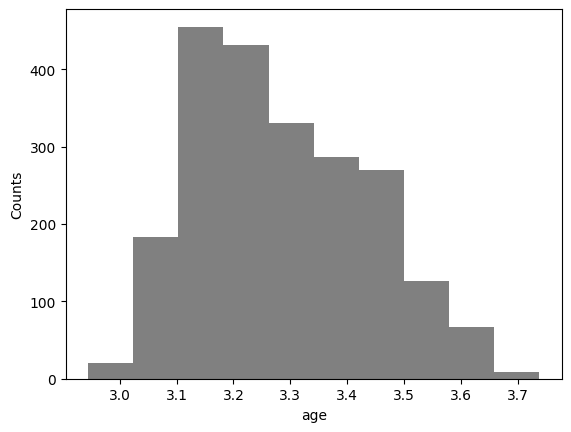

In [60]:
x_val = model_data["age"].copy()
x_val_log = x_val.apply(lambda x: np.log(x))
x_val_sqrt = x_val.apply(lambda x: np.sqrt(x))
plt.hist(x_val_log, color='grey')
plt.ylabel('Counts')
plt.xlabel('age')
plt.plot()

In [ ]:
x_val = model_data["games_played_perc"].copy()
x_val_log = x_val.apply(lambda x: np.log2(x))
plt.hist(x_val_log, color='grey')
plt.ylabel('Counts')
plt.xlabel('games')
plt.plot()

In [ ]:
x_val = model_data["games_started_perc"].copy()
x_val_sqrt = x_val.apply(lambda x: np.sqrt(x))
plt.hist(x_val_sqrt, color='grey')
plt.ylabel('Counts')
plt.xlabel('games_started_perc')
plt.plot()

In [ ]:
x_val = model_data["WS48"].copy()
plt.hist(x_val, color='grey')
plt.ylabel('Counts')
plt.xlabel('WS48')
plt.plot()

In [ ]:
x_val = model_data["PER"].copy()
x_val_log = x_val.apply(lambda x: np.log(x))
plt.hist(x_val, color='grey')
plt.ylabel('Counts')
plt.xlabel('PER')
plt.plot()

In [ ]:
x_val = model_data["team_successes"].copy()
x_val_pow = x_val.apply(lambda x: np.power(x, 3))
plt.hist(x_val_pow, color='grey')
plt.ylabel('Counts')
plt.xlabel('team_successes')
plt.plot()

In [ ]:
x_val = model_data["player_successes"].copy()
x_val_pow = x_val.apply(lambda x: np.power(x, 3))
plt.hist(x_val_pow, color='grey')
plt.ylabel('Counts')
plt.xlabel('player_successes')
plt.plot()

In [119]:
# # #R-squared: 0.519, RESET: p=0.1284729485335086
# reg = smf.ols(formula='np.log(salary_perc) ~ np.log2(age) + games_started_perc + np.power(team_successes, 3) + np.power(player_successes, 3) + np.sqrt(minutes_played)', data=model_data)
# results = reg.fit()
# print(f'results.summary(): \n{results.summary()}\n')

results.summary(): 
                             OLS Regression Results                            
Dep. Variable:     np.log(salary_perc)   R-squared:                       0.519
Model:                             OLS   Adj. R-squared:                  0.518
Method:                  Least Squares   F-statistic:                     469.2
Date:                 Sun, 13 Aug 2023   Prob (F-statistic):               0.00
Time:                         23:32:21   Log-Likelihood:                -2737.9
No. Observations:                 2178   AIC:                             5488.
Df Residuals:                     2172   BIC:                             5522.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [161]:
# # #R-squared: 0.537, RESET: p=0.3872389978457752
reg = smf.ols(formula='np.log(salary_perc) ~ np.log2(age) + games_started_perc + np.power(team_successes, 3) + np.power(player_successes, 3) + avg_minutes_played', data=model_data)
results = reg.fit()
print(f'results.summary(): \n{results.summary()}\n')

results.summary(): 
                             OLS Regression Results                            
Dep. Variable:     np.log(salary_perc)   R-squared:                       0.537
Model:                             OLS   Adj. R-squared:                  0.535
Method:                  Least Squares   F-statistic:                     502.9
Date:                 Sun, 13 Aug 2023   Prob (F-statistic):               0.00
Time:                         23:36:37   Log-Likelihood:                -2698.1
No. Observations:                 2178   AIC:                             5408.
Df Residuals:                     2172   BIC:                             5442.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [162]:
results_np = sm.OLS(results.model.endog, results.model.exog).fit()

In [163]:
# test reset
reset_test = smd.linear_reset(res=results_np, use_f = True)
reset_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.9491281046908072, p=0.3872389978457752, df_denom=2.17e+03, df_num=2>

In [137]:
# WHITE TEST
white_test = smd.het_white(results.resid,  results.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 138.0286802275929, 'Test Statistic p-value': 7.348750859475908e-17, 'F-Statistic': 5.387905495659646, 'F-Test p-value': 1.7034369323134804e-17}


In [129]:
# BREUSCH-PAGAN TEST
bp_test = smd.het_breuschpagan(results.resid, results.model.exog)
#define labels to use for output of BP test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of BP test
print(dict(zip(labels, bp_test)))

{'Test Statistic': 66.66495771340465, 'Test Statistic p-value': 5.057626714783096e-13, 'F-Statistic': 13.716088186240619, 'F-Test p-value': 3.286050996230044e-13}


In [130]:
# BREUSCH-GODFREY TEST
bg_test = smd.acorr_breusch_godfrey(results)

#define labels to use for output of BP test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of BP test
print(dict(zip(labels, bg_test)))

{'Test Statistic': 13.888712499738691, 'Test Statistic p-value': 0.1781285672471317, 'F-Statistic': 1.3875162796788953, 'F-Test p-value': 0.17964335894457562}
